# Payment Date Prediction Model

## Import dataset and packages

In [1]:
#import all required packages and dataset and split datatset into training and test according to clear_date

from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.datasets import load_boston


###read csv and differentiate train and test data according to where create date is null or not
df=pd.read_csv('Downloads\H2HBABBA1586.csv')
dft=df[df['clear_date'].notna()]
test=df[df['clear_date'].isna()]
dft.to_csv('Training.csv')
test.to_csv('Testing.csv')

dft.head()



,business_code,cust_number,name_customer,clear_date,buisness_year,doc_id,posting_date,document_create_date,document_create_date.1,due_in_date,invoice_currency,document type,posting_id,area_business,total_open_amount,baseline_create_date,cust_payment_terms,invoice_id,isOpen
0,CA02,0100031920,AOF SER in,2019-03-08 00:00:00,2019.0,2.960530e+09,2019-02-19,20190219,20190219,20190303.0,CAD,RV,1.0,NaN,17235.74,20190221.0,CA10,2.960530e+09,0
1,U001,0100028715,SPECIALT co,2019-03-22 00:00:00,2019.0,1.928914e+09,2019-03-08,20190306,20190308,20190323.0,USD,RV,1.0,NaN,17709.36,20190308.0,NAA8,1.928914e+09,0
2,CA02,0140106293,ATLANT systems,2019-08-30 00:00:00,2019.0,2.960573e+09,2019-08-14,20190814,20190814,20190902.0,CAD,RV,1.0,NaN,352.42,20190823.0,CA10,2.960573e+09,0
3,U001,0200769623,WAL-MAR,2020-02-26 00:00:00,2020.0,1.930533e+09,2020-02-16,20200216,20200216,20200302.0,USD,RV,1.0,NaN,71648.51,20200216.0,NAH4,1.930533e+09,0
4,CA02,0140106408,WAL-M in,2019-02-08 00:00:00,2019.0,2.960524e+09,2019-01-23,20190123,20190123,20190202.0,CAD,RV,1.0,NaN,1518.50,20190123.0,CA10,2.960524e+09,0


# Data Preprocessing

### Find and drop null values

In [2]:
dft.isna().sum()

business_code                 0
cust_number                   0
name_customer                 0
clear_date                    0
buisness_year                 0
doc_id                        0
posting_date                  0
document_create_date          0
document_create_date.1        0
due_in_date                   0
invoice_currency              0
document type                 0
posting_id                    0
area_business             40000
total_open_amount             0
baseline_create_date          0
cust_payment_terms            0
invoice_id                    1
isOpen                        0
dtype: int64

In [3]:
###drop any column where all row values are null
dft.dropna(how='all',axis=1,inplace=True)

###drop any row where primary key value is null
dft.dropna(how='any',axis=0,inplace=True)

<ipython-input-3-a4a506ff6eed>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dft.dropna(how='all',axis=1,inplace=True)
<ipython-input-3-a4a506ff6eed>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dft.dropna(how='any',axis=0,inplace=True)


In [4]:
###check for duplicated column by transposing rows and columns
transpose=dft.T
transpose.duplicated().sum()

1

In [5]:
#drop duplicated columns
dft=transpose.drop_duplicates(keep='first').T
dft.head()

,business_code,cust_number,name_customer,clear_date,buisness_year,doc_id,posting_date,document_create_date,document_create_date.1,due_in_date,invoice_currency,document type,posting_id,total_open_amount,baseline_create_date,cust_payment_terms,isOpen
0,CA02,0100031920,AOF SER in,2019-03-08 00:00:00,2019.0,2960529720.0,2019-02-19,20190219,20190219,20190303.0,CAD,RV,1.0,17235.74,20190221.0,CA10,0
1,U001,0100028715,SPECIALT co,2019-03-22 00:00:00,2019.0,1928913842.0,2019-03-08,20190306,20190308,20190323.0,USD,RV,1.0,17709.36,20190308.0,NAA8,0
2,CA02,0140106293,ATLANT systems,2019-08-30 00:00:00,2019.0,2960573113.0,2019-08-14,20190814,20190814,20190902.0,CAD,RV,1.0,352.42,20190823.0,CA10,0
3,U001,0200769623,WAL-MAR,2020-02-26 00:00:00,2020.0,1930532862.0,2020-02-16,20200216,20200216,20200302.0,USD,RV,1.0,71648.51,20200216.0,NAH4,0
4,CA02,0140106408,WAL-M in,2019-02-08 00:00:00,2019.0,2960523898.0,2019-01-23,20190123,20190123,20190202.0,CAD,RV,1.0,1518.5,20190123.0,CA10,0


### Convert CAD into USD

In [6]:
dft.loc[dft['invoice_currency']=='CAD','total_open_amount']=dft['total_open_amount']*1.23

### Find our target variable

In [7]:
### find delay i.e. the target value for our dataset
### by finding difference between clear date and due date
dft['clear_date']= pd.to_datetime(dft['clear_date']) 
dft['due_in_date']= pd.to_datetime(dft['due_in_date'],format='%Y%m%d')
delay=dft['clear_date']-dft['due_in_date']
dft['target']=delay
dft.target=dft.target.dt.days.astype(int)
dft.head()

,business_code,cust_number,name_customer,clear_date,buisness_year,doc_id,posting_date,document_create_date,document_create_date.1,due_in_date,invoice_currency,document type,posting_id,total_open_amount,baseline_create_date,cust_payment_terms,isOpen,target
0,CA02,0100031920,AOF SER in,2019-03-08,2019.0,2960529720.0,2019-02-19,20190219,20190219,2019-03-03,CAD,RV,1.0,21199.9602,20190221.0,CA10,0,5
1,U001,0100028715,SPECIALT co,2019-03-22,2019.0,1928913842.0,2019-03-08,20190306,20190308,2019-03-23,USD,RV,1.0,17709.36,20190308.0,NAA8,0,-1
2,CA02,0140106293,ATLANT systems,2019-08-30,2019.0,2960573113.0,2019-08-14,20190814,20190814,2019-09-02,CAD,RV,1.0,433.4766,20190823.0,CA10,0,-3
3,U001,0200769623,WAL-MAR,2020-02-26,2020.0,1930532862.0,2020-02-16,20200216,20200216,2020-03-02,USD,RV,1.0,71648.51,20200216.0,NAH4,0,-5
4,CA02,0140106408,WAL-M in,2019-02-08,2019.0,2960523898.0,2019-01-23,20190123,20190123,2019-02-02,CAD,RV,1.0,1867.755,20190123.0,CA10,0,6


In [8]:
dft.drop(['clear_date'],axis=1)

,business_code,cust_number,name_customer,buisness_year,doc_id,posting_date,document_create_date,document_create_date.1,due_in_date,invoice_currency,document type,posting_id,total_open_amount,baseline_create_date,cust_payment_terms,isOpen,target
0,CA02,0100031920,AOF SER in,2019.0,2960529720.0,2019-02-19,20190219,20190219,2019-03-03,CAD,RV,1.0,21199.9602,20190221.0,CA10,0,5
1,U001,0100028715,SPECIALT co,2019.0,1928913842.0,2019-03-08,20190306,20190308,2019-03-23,USD,RV,1.0,17709.36,20190308.0,NAA8,0,-1
2,CA02,0140106293,ATLANT systems,2019.0,2960573113.0,2019-08-14,20190814,20190814,2019-09-02,CAD,RV,1.0,433.4766,20190823.0,CA10,0,-3
3,U001,0200769623,WAL-MAR,2020.0,1930532862.0,2020-02-16,20200216,20200216,2020-03-02,USD,RV,1.0,71648.51,20200216.0,NAH4,0,-5
4,CA02,0140106408,WAL-M in,2019.0,2960523898.0,2019-01-23,20190123,20190123,2019-02-02,CAD,RV,1.0,1867.755,20190123.0,CA10,0,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49994,U001,0100000222,SMITHFIE foundation,2019.0,1928988398.0,2019-03-21,20190319,20190321,2019-04-05,USD,RV,1.0,9485.43,20190321.0,NAA8,0,10
49995,U001,0200769623,WAL-MAR corp,2019.0,1928996791.0,2019-03-21,20190320,20190321,2019-04-05,USD,RV,1.0,25359.34,20190321.0,NAH4,0,-4
49997,U001,0200418007,AM associates,2019.0,1930027895.0,2019-10-22,20191018,20191022,2019-11-06,USD,RV,1.0,902.63,20191022.0,NAA8,0,6
49998,U001,0200726979,BJ'S corp,2020.0,1930485396.0,2020-02-06,20200205,20200206,2020-02-21,USD,RV,1.0,130.75,20200206.0,NAA8,0,0


In [9]:
dft.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39999 entries, 0 to 49999
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   business_code           39999 non-null  object        
 1   cust_number             39999 non-null  object        
 2   name_customer           39999 non-null  object        
 3   clear_date              39999 non-null  datetime64[ns]
 4   buisness_year           39999 non-null  object        
 5   doc_id                  39999 non-null  object        
 6   posting_date            39999 non-null  object        
 7   document_create_date    39999 non-null  object        
 8   document_create_date.1  39999 non-null  object        
 9   due_in_date             39999 non-null  datetime64[ns]
 10  invoice_currency        39999 non-null  object        
 11  document type           39999 non-null  object        
 12  posting_id              39999 non-null  object

### Find constant and duplicated columns and remove them

In [10]:
dft.nunique()

business_code                 6
cust_number                1316
name_customer              3921
clear_date                  401
buisness_year                 2
doc_id                    39101
posting_date                422
document_create_date        428
document_create_date.1      422
due_in_date                 492
invoice_currency              2
document type                 1
posting_id                    1
total_open_amount         35584
baseline_create_date        435
cust_payment_terms           70
isOpen                        1
target                      189
dtype: int64

In [11]:
dft=dft.drop(['document type','isOpen','posting_id'],axis=1)

In [12]:
dft.business_code.value_counts()

U001    36260
CA02     3097
U013      515
U002      110
U005       12
U007        5
Name: business_code, dtype: int64

In [13]:
dft.business_code=np.where(dft.business_code.isin(['U005','U007']),'Others',dft.business_code)

### Sort data according to posting_date and reset index

In [14]:
dft.sort_values(by=['posting_date'],inplace=True)
dft.reset_index(drop=True,inplace=True)

In [15]:
dft.head()

,business_code,cust_number,name_customer,clear_date,buisness_year,doc_id,posting_date,document_create_date,document_create_date.1,due_in_date,invoice_currency,total_open_amount,baseline_create_date,cust_payment_terms,target
0,U001,0200769623,WAL-MAR in,2019-01-15,2019.0,1928541915.0,2018-12-30,20181229,20181230,2019-01-14,USD,6025.73,20181230.0,NAH4,1
1,U001,0200769623,WAL-MAR associates,2019-01-16,2019.0,1928533975.0,2018-12-30,20181229,20181230,2019-01-14,USD,344.91,20181230.0,NAH4,2
2,U001,0200900909,SYSCO co,2019-02-04,2019.0,1928533119.0,2018-12-30,20181229,20181230,2019-01-31,USD,12938.59,20181230.0,NA32,4
3,U001,0200769623,WAL-MAR associates,2019-01-10,2019.0,1928542474.0,2018-12-30,20181230,20181230,2019-01-14,USD,49910.31,20181230.0,NAH4,-4
4,U001,0200769623,WAL-MAR systems,2019-01-15,2019.0,1928541530.0,2018-12-30,20181229,20181230,2019-01-14,USD,67716.67,20181230.0,NAH4,1


In [16]:
X=dft.drop(['target'],axis=1)

In [17]:
y=dft.target

In [18]:
X_train,X_inter_test,y_train,y_inter_test=train_test_split(X,y,test_size=0.3,random_state=0,shuffle=False)

In [19]:
X_val,X_test,y_val,y_test=train_test_split(X_inter_test,y_inter_test,test_size=0.5,random_state=0,shuffle=False)

In [20]:
X_train.shape,X_val.shape,X_test.shape

((27999, 14), (6000, 14), (6000, 14))

# Exploratory Data Analysis

c:\users\zaid\appdata\local\programs\python\python39\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='target', ylabel='Density'>

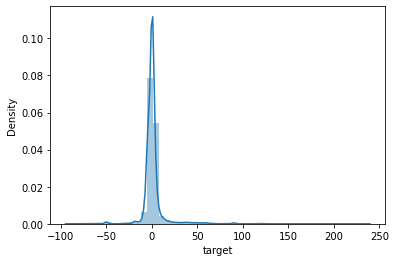

In [21]:
sns.distplot(y_train)

#the target value seems like a normal distribution with some outliers nut arent prominent
#Assumption - model should perform normally

In [22]:
y_train.skew()

3.8695051678106376

<AxesSubplot:xlabel='business_code', ylabel='target'>

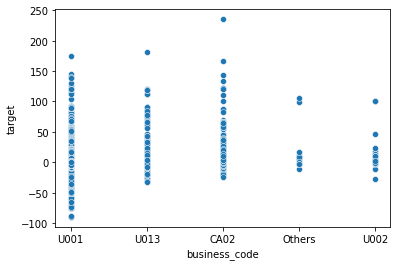

In [23]:
sns.scatterplot(data=X_train.merge(y_train,on=X_train.index),x='business_code',y='target')

<AxesSubplot:xlabel='cust_number', ylabel='target'>

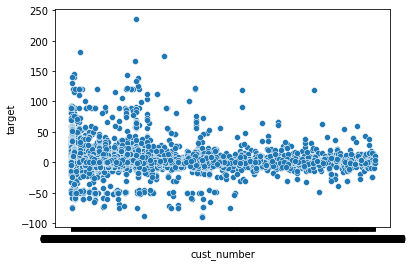

In [24]:
sns.scatterplot(data=X_train.merge(y_train,on=X_train.index),x='cust_number',y='target')

<AxesSubplot:xlabel='name_customer', ylabel='target'>

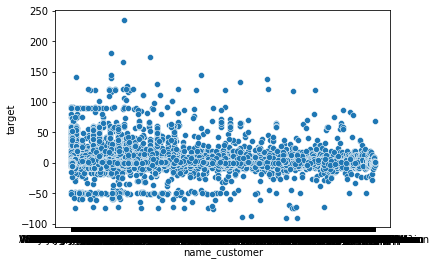

In [25]:
sns.scatterplot(data=X_train.merge(y_train,on=X_train.index),x='name_customer',y='target')

<AxesSubplot:xlabel='clear_date', ylabel='target'>

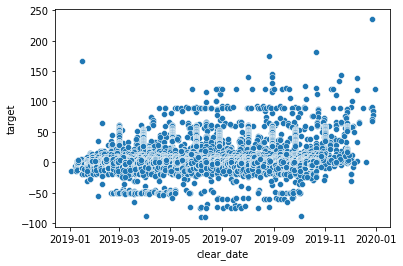

In [26]:
sns.scatterplot(data=X_train.merge(y_train,on=X_train.index),x='clear_date',y='target')

<AxesSubplot:xlabel='buisness_year', ylabel='target'>

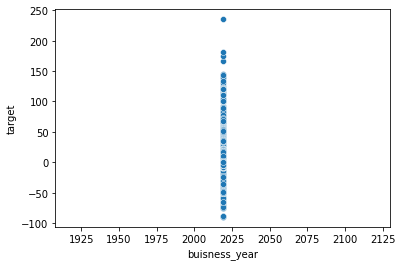

In [27]:
sns.scatterplot(data=X_train.merge(y_train,on=X_train.index),x='buisness_year',y='target')

In [28]:
X_train.total_open_amount=X_train.total_open_amount.astype(float)

c:\users\zaid\appdata\local\programs\python\python39\lib\site-packages\pandas\core\generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


c:\users\zaid\appdata\local\programs\python\python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='total_open_amount'>

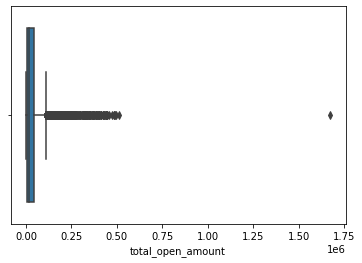

In [29]:
sns.boxplot(X_train.total_open_amount)

In [30]:
X_train.dtypes

business_code                     object
cust_number                       object
name_customer                     object
clear_date                datetime64[ns]
buisness_year                     object
doc_id                            object
posting_date                      object
document_create_date              object
document_create_date.1            object
due_in_date               datetime64[ns]
invoice_currency                  object
total_open_amount                float64
baseline_create_date              object
cust_payment_terms                object
dtype: object

In [31]:
Q1=X_train['total_open_amount'].quantile(0.25)
Q3=X_train['total_open_amount'].quantile(0.75)
IQR=Q3-Q1
print(IQR)

41803.8454


In [32]:
lower=(Q3-1.5*IQR)
upper=(Q3+1.5*IQR)
lower,upper

(-16479.163100000005, 108932.3731)

c:\users\zaid\appdata\local\programs\python\python39\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='total_open_amount', ylabel='Density'>

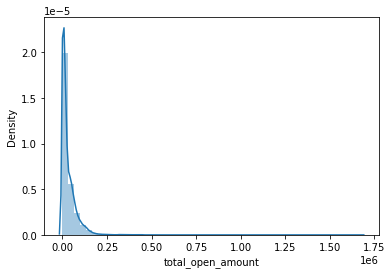

In [33]:
sns.distplot(X_train.total_open_amount)

In [34]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27999 entries, 0 to 27998
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   business_code           27999 non-null  object        
 1   cust_number             27999 non-null  object        
 2   name_customer           27999 non-null  object        
 3   clear_date              27999 non-null  datetime64[ns]
 4   buisness_year           27999 non-null  object        
 5   doc_id                  27999 non-null  object        
 6   posting_date            27999 non-null  object        
 7   document_create_date    27999 non-null  object        
 8   document_create_date.1  27999 non-null  object        
 9   due_in_date             27999 non-null  datetime64[ns]
 10  invoice_currency        27999 non-null  object        
 11  total_open_amount       27999 non-null  float64       
 12  baseline_create_date    27999 non-null  object

<AxesSubplot:xlabel='doc_id', ylabel='target'>

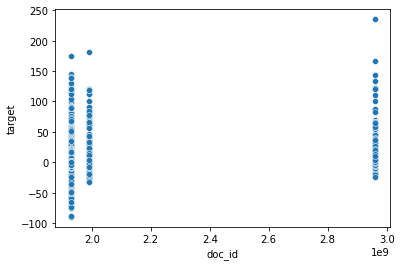

In [35]:
sns.scatterplot(data=X_train.merge(y_train,on=X_train.index),x='doc_id',y='target')

<AxesSubplot:xlabel='posting_date', ylabel='target'>

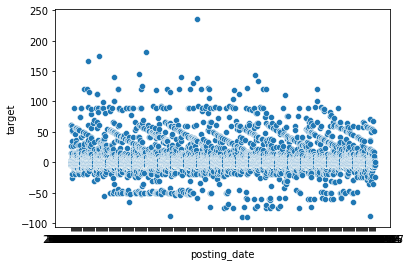

In [36]:
sns.scatterplot(data=X_train.merge(y_train,on=X_train.index),x='posting_date',y='target')

<AxesSubplot:xlabel='document_create_date', ylabel='target'>

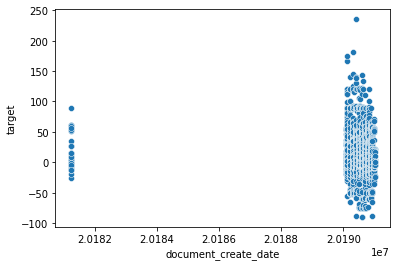

In [37]:
sns.scatterplot(data=X_train.merge(y_train,on=X_train.index),x='document_create_date',y='target')

<AxesSubplot:xlabel='document_create_date.1', ylabel='target'>

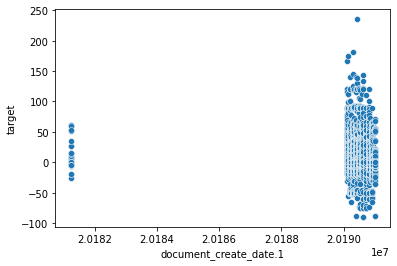

In [38]:
sns.scatterplot(data=X_train.merge(y_train,on=X_train.index),x='document_create_date.1',y='target')

<AxesSubplot:xlabel='due_in_date', ylabel='target'>

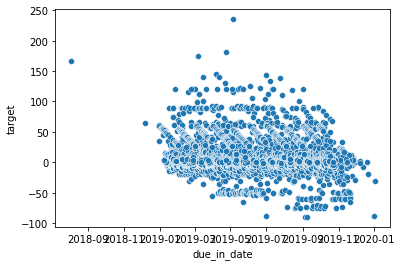

In [39]:
sns.scatterplot(data=X_train.merge(y_train,on=X_train.index),x='due_in_date',y='target')

<AxesSubplot:xlabel='invoice_currency', ylabel='target'>

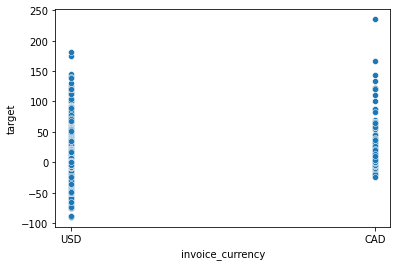

In [40]:
sns.scatterplot(data=X_train.merge(y_train,on=X_train.index),x='invoice_currency',y='target')

<AxesSubplot:xlabel='total_open_amount', ylabel='target'>

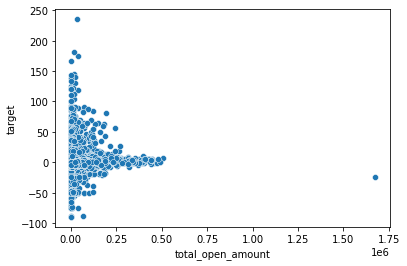

In [41]:
sns.scatterplot(data=X_train.merge(y_train,on=X_train.index),x='total_open_amount',y='target')

<AxesSubplot:xlabel='baseline_create_date', ylabel='target'>

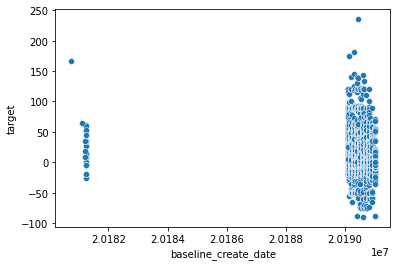

In [42]:
sns.scatterplot(data=X_train.merge(y_train,on=X_train.index),x='baseline_create_date',y='target')

<AxesSubplot:xlabel='cust_payment_terms', ylabel='target'>

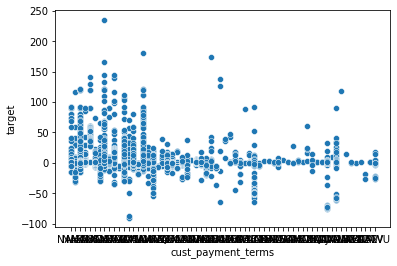

In [43]:
sns.scatterplot(data=X_train.merge(y_train,on=X_train.index),x='cust_payment_terms',y='target')

In [44]:
y_train

0         1
1         2
2         4
3        -4
4         1
         ..
27994     0
27995     1
27996    -5
27997     0
27998   -25
Name: target, Length: 27999, dtype: int32

In [45]:
X_train.total_open_amount=X_train.total_open_amount.astype(float)


c:\users\zaid\appdata\local\programs\python\python39\lib\site-packages\pandas\core\generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


# Feature Engineering

In [46]:
X_train.columns

Index(['business_code', 'cust_number', 'name_customer', 'clear_date',
       'buisness_year', 'doc_id', 'posting_date', 'document_create_date',
       'document_create_date.1', 'due_in_date', 'invoice_currency',
       'total_open_amount', 'baseline_create_date', 'cust_payment_terms'],
      dtype='object')

In [47]:
X_train.nunique()

business_code                 5
cust_number                1216
name_customer              3398
clear_date                  284
buisness_year                 1
doc_id                    27381
posting_date                282
document_create_date        289
document_create_date.1      282
due_in_date                 340
invoice_currency              2
total_open_amount         25122
baseline_create_date        296
cust_payment_terms           64
dtype: int64

### Find and drop constant features

In [48]:
const_features = [cols for cols in X_train.columns if len(list(X_train[cols].unique())) == 1]
const_features

['buisness_year']

In [49]:
X_train=X_train.drop(const_features,axis=1)
X_test=X_test.drop(const_features,axis=1)
X_val=X_val.drop(const_features,axis=1)

### Label Encoding

In [50]:
# LABEL ENCODING for business code

label_encoder = LabelEncoder()
X_train['business_code'] = label_encoder.fit_transform(X_train['business_code'])
X_test['business_code'] = label_encoder.fit_transform(X_test['business_code'])
X_val['business_code'] = label_encoder.fit_transform(X_val['business_code'])

X_train.head()

,business_code,cust_number,name_customer,clear_date,doc_id,posting_date,document_create_date,document_create_date.1,due_in_date,invoice_currency,total_open_amount,baseline_create_date,cust_payment_terms
0,2,0200769623,WAL-MAR in,2019-01-15,1928541915.0,2018-12-30,20181229,20181230,2019-01-14,USD,6025.73,20181230.0,NAH4
1,2,0200769623,WAL-MAR associates,2019-01-16,1928533975.0,2018-12-30,20181229,20181230,2019-01-14,USD,344.91,20181230.0,NAH4
2,2,0200900909,SYSCO co,2019-02-04,1928533119.0,2018-12-30,20181229,20181230,2019-01-31,USD,12938.59,20181230.0,NA32
3,2,0200769623,WAL-MAR associates,2019-01-10,1928542474.0,2018-12-30,20181230,20181230,2019-01-14,USD,49910.31,20181230.0,NAH4
4,2,0200769623,WAL-MAR systems,2019-01-15,1928541530.0,2018-12-30,20181229,20181230,2019-01-14,USD,67716.67,20181230.0,NAH4


In [51]:
# LABEL ENCODING for cust_payment_terms

label_encoder = LabelEncoder()
X_train['cust_payment_terms'] = label_encoder.fit_transform(X_train['cust_payment_terms'])
X_test['cust_payment_terms'] = label_encoder.fit_transform(X_test['cust_payment_terms'])
X_val['cust_payment_terms'] = label_encoder.fit_transform(X_val['cust_payment_terms'])

X_train.head()

,business_code,cust_number,name_customer,clear_date,doc_id,posting_date,document_create_date,document_create_date.1,due_in_date,invoice_currency,total_open_amount,baseline_create_date,cust_payment_terms
0,2,0200769623,WAL-MAR in,2019-01-15,1928541915.0,2018-12-30,20181229,20181230,2019-01-14,USD,6025.73,20181230.0,32
1,2,0200769623,WAL-MAR associates,2019-01-16,1928533975.0,2018-12-30,20181229,20181230,2019-01-14,USD,344.91,20181230.0,32
2,2,0200900909,SYSCO co,2019-02-04,1928533119.0,2018-12-30,20181229,20181230,2019-01-31,USD,12938.59,20181230.0,12
3,2,0200769623,WAL-MAR associates,2019-01-10,1928542474.0,2018-12-30,20181230,20181230,2019-01-14,USD,49910.31,20181230.0,32
4,2,0200769623,WAL-MAR systems,2019-01-15,1928541530.0,2018-12-30,20181229,20181230,2019-01-14,USD,67716.67,20181230.0,32


In [52]:
X_train.cust_number.nunique()

1216

In [53]:
X_train.cust_number.value_counts()

0200769623    6007
0200726979    1046
0200762301     777
0200759878     700
200769623      609
              ... 
100019293        1
0100046482       1
0200525326       1
0200703231       1
0200326954       1
Name: cust_number, Length: 1216, dtype: int64

In [54]:
X_train.name_customer.value_counts()

WAL-MAR llc            647
WAL-MAR corp           625
WAL-MAR us             611
WAL-MAR corporation    607
WAL-MAR in             602
                      ... 
PAPA systems             1
SUIS foundation          1
BAS in                   1
GARDEN trust             1
LAKE trust               1
Name: name_customer, Length: 3398, dtype: int64

In [55]:
# LABEL ENCODING for business code

label_encoder = LabelEncoder()
X_train['name_customer'] = label_encoder.fit_transform(X_train['name_customer'])
X_test['name_customer'] = label_encoder.fit_transform(X_test['name_customer'])
X_val['name_customer'] = label_encoder.fit_transform(X_val['name_customer'])

X_train.head()

,business_code,cust_number,name_customer,clear_date,doc_id,posting_date,document_create_date,document_create_date.1,due_in_date,invoice_currency,total_open_amount,baseline_create_date,cust_payment_terms
0,2,0200769623,3294,2019-01-15,1928541915.0,2018-12-30,20181229,20181230,2019-01-14,USD,6025.73,20181230.0,32
1,2,0200769623,3289,2019-01-16,1928533975.0,2018-12-30,20181229,20181230,2019-01-14,USD,344.91,20181230.0,32
2,2,0200900909,3041,2019-02-04,1928533119.0,2018-12-30,20181229,20181230,2019-01-31,USD,12938.59,20181230.0,12
3,2,0200769623,3289,2019-01-10,1928542474.0,2018-12-30,20181230,20181230,2019-01-14,USD,49910.31,20181230.0,32
4,2,0200769623,3296,2019-01-15,1928541530.0,2018-12-30,20181229,20181230,2019-01-14,USD,67716.67,20181230.0,32


In [56]:
# LABEL ENCODING for CUST_NUMBER

label_encoder = LabelEncoder()
X_train['cust_number'] = label_encoder.fit_transform(X_train['cust_number'])
X_test['cust_number'] = label_encoder.fit_transform(X_test['cust_number'])
X_val['cust_number'] = label_encoder.fit_transform(X_val['cust_number'])

X_train.head()

,business_code,cust_number,name_customer,clear_date,doc_id,posting_date,document_create_date,document_create_date.1,due_in_date,invoice_currency,total_open_amount,baseline_create_date,cust_payment_terms
0,2,711,3294,2019-01-15,1928541915.0,2018-12-30,20181229,20181230,2019-01-14,USD,6025.73,20181230.0,32
1,2,711,3289,2019-01-16,1928533975.0,2018-12-30,20181229,20181230,2019-01-14,USD,344.91,20181230.0,32
2,2,824,3041,2019-02-04,1928533119.0,2018-12-30,20181229,20181230,2019-01-31,USD,12938.59,20181230.0,12
3,2,711,3289,2019-01-10,1928542474.0,2018-12-30,20181230,20181230,2019-01-14,USD,49910.31,20181230.0,32
4,2,711,3296,2019-01-15,1928541530.0,2018-12-30,20181229,20181230,2019-01-14,USD,67716.67,20181230.0,32


In [57]:
X_train.dtypes

business_code                      int32
cust_number                        int32
name_customer                      int32
clear_date                datetime64[ns]
doc_id                            object
posting_date                      object
document_create_date              object
document_create_date.1            object
due_in_date               datetime64[ns]
invoice_currency                  object
total_open_amount                float64
baseline_create_date              object
cust_payment_terms                 int32
dtype: object

In [58]:
### Convert doc_id to float

In [59]:
X_train.doc_id=X_train.doc_id.astype(float)
X_test.doc_id=X_test.doc_id.astype(float)
X_val.doc_id=X_val.doc_id.astype(float)

In [60]:
X_train.dtypes

business_code                      int32
cust_number                        int32
name_customer                      int32
clear_date                datetime64[ns]
doc_id                           float64
posting_date                      object
document_create_date              object
document_create_date.1            object
due_in_date               datetime64[ns]
invoice_currency                  object
total_open_amount                float64
baseline_create_date              object
cust_payment_terms                 int32
dtype: object

In [61]:
# function will delete a column from train , val and test
def delcol(col ,traindf = X_train,valdf = X_val,testdf = X_test):
    traindf.drop(col, axis =1,inplace=True)
    valdf.drop(col,axis=1 , inplace=True)
    testdf.drop(col,axis=1 , inplace=True)

    return traindf,valdf ,testdf

In [62]:
X_train ,X_val, X_test = delcol(['clear_date'])

#### Convert datetime columns to datetime and extract their data and drop them

In [63]:
X_train.posting_date=pd.to_datetime(X_train.posting_date)
X_test.posting_date=pd.to_datetime(X_test.posting_date)
X_val.posting_date=pd.to_datetime(X_val.posting_date)

In [64]:
X_train.document_create_date=pd.to_datetime(X_train.document_create_date)
X_test.document_create_date=pd.to_datetime(X_test.document_create_date)
X_val.document_create_date=pd.to_datetime(X_val.document_create_date)

In [65]:
X_train['document_create_date.1']=pd.to_datetime(X_train['document_create_date.1'])
X_test['document_create_date.1']=pd.to_datetime(X_test['document_create_date.1'])
X_val['document_create_date.1']=pd.to_datetime(X_val['document_create_date.1'])


In [66]:
X_train['posting_date_year'] = X_train['posting_date'].dt.year
X_train['posting_date_dayofweek'] = X_train['posting_date'].dt.dayofweek
X_train['posting_date_month'] = X_train['posting_date'].dt.month
X_train['posting_date_day'] = X_train['posting_date'].dt.day
X_train['posting_date_quarter'] = X_train['posting_date'].dt.quarter

X_test['posting_date_year'] = X_test['posting_date'].dt.year
X_test['posting_date_dayofweek'] = X_test['posting_date'].dt.dayofweek
X_test['posting_date_month'] = X_test['posting_date'].dt.month
X_test['posting_date_day'] = X_test['posting_date'].dt.day
X_test['posting_date_quarter'] = X_test['posting_date'].dt.quarter

X_val['posting_date_year'] = X_val['posting_date'].dt.year
X_val['posting_date_dayofweek'] = X_val['posting_date'].dt.dayofweek
X_val['posting_date_month'] = X_val['posting_date'].dt.month
X_val['posting_date_day'] = X_val['posting_date'].dt.day
X_val['posting_date_quarter'] = X_val['posting_date'].dt.quarter

In [67]:
X_train ,X_val, X_test = delcol(['posting_date'])

In [68]:
X_train['document_create_date_year'] = X_train['document_create_date'].dt.year
X_train['document_create_date_dayofweek'] = X_train['document_create_date'].dt.dayofweek
X_train['document_create_date_month'] = X_train['document_create_date'].dt.month
X_train['document_create_date_day'] = X_train['document_create_date'].dt.day
X_train['document_create_date_quarter'] = X_train['document_create_date'].dt.quarter

X_test['document_create_date_year'] = X_test['document_create_date'].dt.year
X_test['document_create_date_dayofweek'] = X_test['document_create_date'].dt.dayofweek
X_test['document_create_date_month'] = X_test['document_create_date'].dt.month
X_test['document_create_date_day'] = X_test['document_create_date'].dt.day
X_test['document_create_date_quarter'] = X_test['document_create_date'].dt.quarter

X_val['document_create_date_year'] = X_val['document_create_date'].dt.year
X_val['document_create_date_dayofweek'] = X_val['document_create_date'].dt.dayofweek
X_val['document_create_date_month'] = X_val['document_create_date'].dt.month
X_val['document_create_date_day'] = X_val['document_create_date'].dt.day
X_val['document_create_date_quarter'] = X_val['document_create_date'].dt.quarter

In [69]:
X_train ,X_val, X_test = delcol(['document_create_date'])

In [70]:
X_train['document_create_date1_year'] = X_train['document_create_date.1'].dt.year
X_train['document_create_date1_dayofweek'] = X_train['document_create_date.1'].dt.dayofweek
X_train['document_create_date1_month'] = X_train['document_create_date.1'].dt.month
X_train['document_create_date1_day'] = X_train['document_create_date.1'].dt.day
X_train['document_create_date1_quarter'] = X_train['document_create_date.1'].dt.quarter

X_test['document_create_date1_year'] = X_test['document_create_date.1'].dt.year
X_test['document_create_date1_dayofweek'] = X_test['document_create_date.1'].dt.dayofweek
X_test['document_create_date1_month'] = X_test['document_create_date.1'].dt.month
X_test['document_create_date1_day'] = X_test['document_create_date.1'].dt.day
X_test['document_create_date1_quarter'] = X_test['document_create_date.1'].dt.quarter

X_val['document_create_date1_year'] = X_val['document_create_date.1'].dt.year
X_val['document_create_date1_dayofweek'] = X_val['document_create_date.1'].dt.dayofweek
X_val['document_create_date1_month'] = X_val['document_create_date.1'].dt.month
X_val['document_create_date1_day'] = X_val['document_create_date.1'].dt.day
X_val['document_create_date1_quarter'] = X_val['document_create_date.1'].dt.quarter

In [71]:
X_train ,X_val, X_test = delcol(['document_create_date.1'])

In [72]:
X_train.dtypes

business_code                               int32
cust_number                                 int32
name_customer                               int32
doc_id                                    float64
due_in_date                        datetime64[ns]
invoice_currency                           object
total_open_amount                         float64
baseline_create_date                       object
cust_payment_terms                          int32
posting_date_year                           int64
posting_date_dayofweek                      int64
posting_date_month                          int64
posting_date_day                            int64
posting_date_quarter                        int64
document_create_date_year                   int64
document_create_date_dayofweek              int64
document_create_date_month                  int64
document_create_date_day                    int64
document_create_date_quarter                int64
document_create_date1_year                  int64


In [73]:
X_train ,X_val, X_test = delcol(['invoice_currency'])

In [74]:
X_test.total_open_amount=X_test.total_open_amount.astype(float)
X_val.total_open_amount=X_val.total_open_amount.astype(float)

In [75]:
X_train.baseline_create_date=pd.to_datetime(X_train.baseline_create_date)
X_test.baseline_create_date=pd.to_datetime(X_test.baseline_create_date)
X_val.baseline_create_date=pd.to_datetime(X_val.baseline_create_date)

In [76]:
X_train['baseline_create_date_year'] = X_train['baseline_create_date'].dt.year
X_train['baseline_create_date_dayofweek'] = X_train['baseline_create_date'].dt.dayofweek
X_train['baseline_create_date_month'] = X_train['baseline_create_date'].dt.month
X_train['baseline_create_date_day'] = X_train['baseline_create_date'].dt.day
X_train['baseline_create_date_quarter'] = X_train['baseline_create_date'].dt.quarter

X_test['baseline_create_date_year'] = X_test['baseline_create_date'].dt.year
X_test['baseline_create_date_dayofweek'] = X_test['baseline_create_date'].dt.dayofweek
X_test['baseline_create_date_month'] = X_test['baseline_create_date'].dt.month
X_test['baseline_create_date_day'] = X_test['baseline_create_date'].dt.day
X_test['baseline_create_date_quarter'] = X_test['baseline_create_date'].dt.quarter

X_val['baseline_create_date_year'] = X_val['baseline_create_date'].dt.year
X_val['baseline_create_date_dayofweek'] = X_val['baseline_create_date'].dt.dayofweek
X_val['baseline_create_date_month'] = X_val['baseline_create_date'].dt.month
X_val['baseline_create_date_day'] = X_val['baseline_create_date'].dt.day
X_val['baseline_create_date_quarter'] = X_val['baseline_create_date'].dt.quarter

In [77]:
X_train['due_in_date_year'] = X_train['due_in_date'].dt.year
X_train['due_in_date_dayofweek'] = X_train['due_in_date'].dt.dayofweek
X_train['due_in_date_month'] = X_train['due_in_date'].dt.month
X_train['due_in_date_day'] = X_train['due_in_date'].dt.day
X_train['due_in_date_quarter'] = X_train['due_in_date'].dt.quarter

X_test['due_in_date_year'] = X_test['due_in_date'].dt.year
X_test['due_in_date_dayofweek'] = X_test['due_in_date'].dt.dayofweek
X_test['due_in_date_month'] = X_test['due_in_date'].dt.month
X_test['due_in_date_day'] = X_test['due_in_date'].dt.day
X_test['due_in_date_quarter'] = X_test['due_in_date'].dt.quarter

X_val['due_in_date_year'] = X_val['due_in_date'].dt.year
X_val['due_in_date_dayofweek'] = X_val['due_in_date'].dt.dayofweek
X_val['due_in_date_month'] = X_val['due_in_date'].dt.month
X_val['due_in_date_day'] = X_val['due_in_date'].dt.day
X_val['due_in_date_quarter'] = X_val['due_in_date'].dt.quarter

In [78]:
X_train ,X_val, X_test = delcol(['baseline_create_date'])
X_train ,X_val, X_test = delcol(['due_in_date'])

In [79]:
X_train.nunique()

business_code                          5
cust_number                         1216
name_customer                       3398
doc_id                             27381
total_open_amount                  25122
cust_payment_terms                    64
posting_date_year                      2
posting_date_dayofweek                 7
posting_date_month                    11
posting_date_day                      31
posting_date_quarter                   4
document_create_date_year              1
document_create_date_dayofweek         1
document_create_date_month             1
document_create_date_day               1
document_create_date_quarter           1
document_create_date1_year             1
document_create_date1_dayofweek        1
document_create_date1_month            1
document_create_date1_day              1
document_create_date1_quarter          1
baseline_create_date_year              1
baseline_create_date_dayofweek         1
baseline_create_date_month             1
baseline_create_

In [80]:
X_train=X_train.drop(['document_create_date_year','document_create_date_dayofweek','document_create_date_month','document_create_date_day'
             ,'document_create_date_quarter','document_create_date1_year','document_create_date1_dayofweek','document_create_date1_month'
              ,'document_create_date1_day','document_create_date1_quarter','baseline_create_date_year'],axis=1)

In [81]:
X_test=X_test.drop(['document_create_date_year','document_create_date_dayofweek','document_create_date_month','document_create_date_day'
             ,'document_create_date_quarter','document_create_date1_year','document_create_date1_dayofweek','document_create_date1_month'
              ,'document_create_date1_day','document_create_date1_quarter','baseline_create_date_year'],axis=1)
X_val=X_val.drop(['document_create_date_year','document_create_date_dayofweek','document_create_date_month','document_create_date_day'
             ,'document_create_date_quarter','document_create_date1_year','document_create_date1_dayofweek','document_create_date1_month'
              ,'document_create_date1_day','document_create_date1_quarter','baseline_create_date_year'],axis=1)

In [82]:
X_train.dtypes

business_code                       int32
cust_number                         int32
name_customer                       int32
doc_id                            float64
total_open_amount                 float64
cust_payment_terms                  int32
posting_date_year                   int64
posting_date_dayofweek              int64
posting_date_month                  int64
posting_date_day                    int64
posting_date_quarter                int64
baseline_create_date_dayofweek      int64
baseline_create_date_month          int64
baseline_create_date_day            int64
baseline_create_date_quarter        int64
due_in_date_year                    int64
due_in_date_dayofweek               int64
due_in_date_month                   int64
due_in_date_day                     int64
due_in_date_quarter                 int64
dtype: object

In [83]:
X_train.head()

,business_code,cust_number,name_customer,doc_id,total_open_amount,cust_payment_terms,posting_date_year,posting_date_dayofweek,posting_date_month,posting_date_day,posting_date_quarter,baseline_create_date_dayofweek,baseline_create_date_month,baseline_create_date_day,baseline_create_date_quarter,due_in_date_year,due_in_date_dayofweek,due_in_date_month,due_in_date_day,due_in_date_quarter
0,2,711,3294,1.928542e+09,6025.73,32,2018,6,12,30,4,3,1,1,1,2019,0,1,14,1
1,2,711,3289,1.928534e+09,344.91,32,2018,6,12,30,4,3,1,1,1,2019,0,1,14,1
2,2,824,3041,1.928533e+09,12938.59,12,2018,6,12,30,4,3,1,1,1,2019,3,1,31,1
3,2,711,3289,1.928542e+09,49910.31,32,2018,6,12,30,4,3,1,1,1,2019,0,1,14,1
4,2,711,3296,1.928542e+09,67716.67,32,2018,6,12,30,4,3,1,1,1,2019,0,1,14,1


## Feature Selection

In [84]:
X_train,X_val ,X_test = delcol(['baseline_create_date_dayofweek'])

In [85]:
X_train,X_val ,X_test = delcol(['baseline_create_date_month'])
X_train,X_val ,X_test = delcol(['baseline_create_date_quarter'])

X_train=X_train.drop(['baseline_create_date_day','document_create_date_year','document_create_date_dayofweek','document_create_date_month','document_create_date_day'
             ,'document_create_date_quarter','document_create_date1_year','document_create_date1_dayofweek','document_create_date1_month'
              ,'document_create_date1_day','document_create_date1_quarter'],axis=1)
X_test=X_test.drop(['baseline_create_date_day','document_create_date_year','document_create_date_dayofweek','document_create_date_month','document_create_date_day'
             ,'document_create_date_quarter','document_create_date1_year','document_create_date1_dayofweek','document_create_date1_month'
              ,'document_create_date1_day','document_create_date1_quarter'],axis=1)
X_val=X_val.drop(['baseline_create_date_day','document_create_date_year','document_create_date_dayofweek','document_create_date_month','document_create_date_day'
             ,'document_create_date_quarter','document_create_date1_year','document_create_date1_dayofweek','document_create_date1_month'
              ,'document_create_date1_day','document_create_date1_quarter'],axis=1)

In [86]:
X_train.dtypes

business_code                  int32
cust_number                    int32
name_customer                  int32
doc_id                       float64
total_open_amount            float64
cust_payment_terms             int32
posting_date_year              int64
posting_date_dayofweek         int64
posting_date_month             int64
posting_date_day               int64
posting_date_quarter           int64
baseline_create_date_year      int64
due_in_date_year               int64
due_in_date_dayofweek          int64
due_in_date_month              int64
due_in_date_day                int64
due_in_date_quarter            int64
dtype: object

In [87]:
X_val=X_val.drop(['posting_date_year','posting_date_dayofweek'
                 ,'posting_date_month','posting_date_day','posting_date_quarter','due_in_date_year',
                 'due_in_date_dayofweek','due_in_date_month','due_in_date_day','due_in_date_quarter'],axis=1)
X_test=X_test.drop(['posting_date_year','posting_date_dayofweek'
                 ,'posting_date_month','posting_date_day','posting_date_quarter','due_in_date_year',
                 'due_in_date_dayofweek','due_in_date_month','due_in_date_day','due_in_date_quarter'],axis=1)
X_train=X_train.drop(['posting_date_year','posting_date_dayofweek'
                 ,'posting_date_month','posting_date_day','posting_date_quarter','due_in_date_year',
                 'due_in_date_dayofweek','due_in_date_month','due_in_date_day','due_in_date_quarter'],axis=1)

In [88]:
aaa=X_train.merge(y_train , on = X_train.index ).corr()


In [89]:
from sklearn.feature_selection import VarianceThreshold
sel = VarianceThreshold(0)
sel.fit(X_train)

VarianceThreshold(threshold=0)

In [90]:
# Drop constant columns

In [91]:
constant_filter = VarianceThreshold(threshold=0)
constant_filter.fit(X_train)

len(X_train.columns[constant_filter.get_support()])

constant_columns = [column for column in X_train.columns
                    if column not in X_train.columns[constant_filter.get_support()]]

X_train.drop(labels=constant_columns, axis=1, inplace=True)
X_test.drop(labels=constant_columns, axis=1, inplace=True)
X_val.drop(labels=constant_columns, axis=1, inplace=True)

In [92]:
X_train.columns

Index(['business_code', 'cust_number', 'name_customer', 'doc_id',
       'total_open_amount', 'cust_payment_terms'],
      dtype='object')

In [93]:
X_train.total_open_amount.nunique()

25122

In [94]:
qconstant_filter = VarianceThreshold(threshold=0.8)
qconstant_filter.fit(X_train)



VarianceThreshold(threshold=0.8)

In [95]:
len(X_train.columns[qconstant_filter.get_support()])


5

In [96]:
qconstant_columns = [column for column in X_train.columns
                    if column not in X_train.columns[qconstant_filter.get_support()]]

print(len(qconstant_columns))

1


In [97]:
X_train.head()

,business_code,cust_number,name_customer,doc_id,total_open_amount,cust_payment_terms
0,2,711,3294,1.928542e+09,6025.73,32
1,2,711,3289,1.928534e+09,344.91,32
2,2,824,3041,1.928533e+09,12938.59,12
3,2,711,3289,1.928542e+09,49910.31,32
4,2,711,3296,1.928542e+09,67716.67,32


In [98]:
for column in qconstant_columns:
    print(column)

business_code


In [99]:
X_train = qconstant_filter.transform(X_train)

X_val = qconstant_filter.transform(X_val)
X_test = qconstant_filter.transform(X_test)


In [100]:
##dropped quasi constant columns

<AxesSubplot:title={'center':'Pearson Correlation of Features'}>

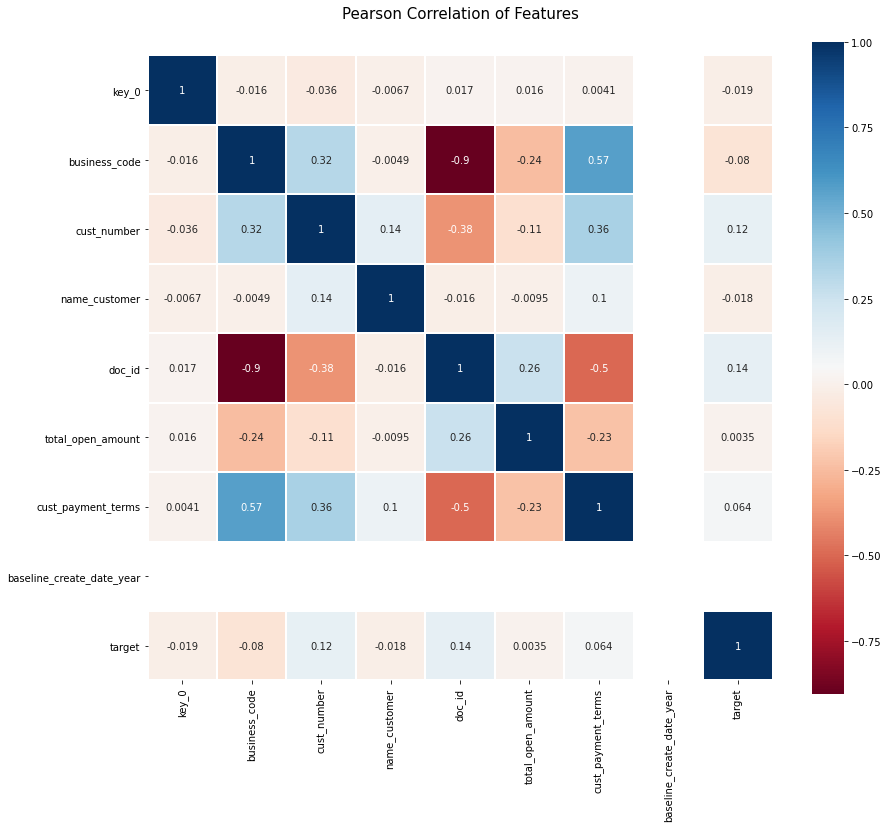

In [101]:
#Feature Selection

#corrmat = X_train.merge(y_train , on = X_train.index).corr()
# plt.subplots(figsize=(12,9))
# sns.heatmap(corrmat, vmax=0.9, square=True)


colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(aaa,linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

In [102]:
sel.variances_

array([3.62760051e-01, 1.21500000e+03, 3.39700000e+03, 1.03208325e+09,
       1.67345587e+06, 6.30000000e+01, 0.00000000e+00])

## Modelling

In [103]:

from sklearn.linear_model import LinearRegression
base_model = LinearRegression()
base_model.fit(X_train, y_train)

LinearRegression()

In [104]:
y_predict = base_model.predict(X_val)

In [105]:
from sklearn.metrics import mean_squared_error

mean_squared_error(y_val, y_predict, squared=False)

7.504160400180648

In [106]:
base_model.score(X_train,y_train)

0.07027746551251024

In [107]:
base_model.coef_

array([ 9.28111328e-03, -5.52523790e-04,  1.18631995e-08, -4.60843757e-06,
        1.46239369e-01])

In [108]:
met = pd.DataFrame(zip(y_predict , y_test),columns=['Predicted','Actuals'])

In [109]:
(abs(met.Predicted-met.Actuals)/met.Actuals).mean()

inf

In [110]:
from sklearn.tree import DecisionTreeRegressor
regressor = DecisionTreeRegressor(random_state=0 , max_depth=5,splitter='best')

In [111]:
regressor.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=5, random_state=0)

In [112]:
y_predict2 = regressor.predict(X_val)

In [113]:
mean_squared_error(y_val, y_predict2, squared=False)

8.191245636068057

In [114]:
regressor.score(X_test,y_test)

-0.188749336322505

In [115]:
y_predict_test = regressor.predict(X_test)
mean_squared_error(y_test, y_predict_test, squared=False)

10.877069464426603

In [116]:
regressor.score(X_val,y_val)

-0.4220878495999072

In [117]:
mean_squared_error(y_val, y_predict2, squared=False)

8.191245636068057

In [118]:
y_predict_test = regressor.predict(X_test)
mean_squared_error(y_test, y_predict_test, squared=False)

10.877069464426603

## Main Test

In [119]:
### Do all pre processing , feature engineering and feature seection procedure on main test data

In [120]:
dftt=test

In [121]:
dftt.isna().sum()

business_code                 0
cust_number                   0
name_customer                 0
clear_date                10000
buisness_year                 0
doc_id                        0
posting_date                  0
document_create_date          0
document_create_date.1        0
due_in_date                   0
invoice_currency              0
document type                 0
posting_id                    0
area_business             10000
total_open_amount             0
baseline_create_date          0
cust_payment_terms            0
invoice_id                    0
isOpen                        0
dtype: int64

In [122]:
dftt.dropna(how='all',axis=1,inplace=True)

<ipython-input-122-8e8d03e71413>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dftt.dropna(how='all',axis=1,inplace=True)


In [123]:
dftt.loc[dftt['invoice_currency']=='CAD','total_open_amount']=dftt['total_open_amount']*1.23

c:\users\zaid\appdata\local\programs\python\python39\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [124]:
dftt=dftt.drop(['document type','isOpen','posting_id'],axis=1)

In [125]:
dftt.business_code=np.where(dftt.business_code.isin(['U005','U007']),'Others',dftt.business_code)

In [126]:
dftt.sort_values(by=['posting_date'],inplace=True)
dftt.reset_index(drop=True,inplace=True)

In [127]:
const_features = [cols for cols in dftt.columns if len(list(dftt[cols].unique())) == 1]
const_features

['buisness_year']

In [128]:
dftt=dftt.drop(const_features,axis=1)


In [129]:
# LABEL ENCODING 

label_encoder = LabelEncoder()
dftt['business_code'] = label_encoder.fit_transform(dftt['business_code'])
dftt['cust_number'] = label_encoder.fit_transform(dftt['cust_number'])
dftt['name_customer'] = label_encoder.fit_transform(dftt['name_customer'])
dftt['cust_payment_terms'] = label_encoder.fit_transform(dftt['cust_payment_terms'])

In [130]:
dftt.posting_date=pd.to_datetime(dftt.posting_date)
dftt.document_create_date=pd.to_datetime(dftt.document_create_date)
dftt['document_create_date.1']=pd.to_datetime(dftt['document_create_date.1'])


In [131]:
dftt['posting_date_year'] = dftt['posting_date'].dt.year
dftt['posting_date_dayofweek'] = dftt['posting_date'].dt.dayofweek
dftt['posting_date_month'] = dftt['posting_date'].dt.month
dftt['posting_date_day'] = dftt['posting_date'].dt.day
dftt['posting_date_quarter'] = dftt['posting_date'].dt.quarter

In [132]:
dftt=dftt.drop(['posting_date'],axis=1)

In [133]:
dftt['document_create_date_year'] = dftt['document_create_date'].dt.year
dftt['document_create_date_dayofweek'] = dftt['document_create_date'].dt.dayofweek
dftt['document_create_date_month'] = dftt['document_create_date'].dt.month
dftt['document_create_date_day'] = dftt['document_create_date'].dt.day
dftt['document_create_date_quarter'] = dftt['document_create_date'].dt.quarter

In [134]:
dftt=dftt.drop(['document_create_date'],axis=1)

In [135]:
dftt['document_create_date1_year'] = dftt['document_create_date.1'].dt.year
dftt['document_create_date1_dayofweek'] = dftt['document_create_date.1'].dt.dayofweek
dftt['document_create_date1_month'] = dftt['document_create_date.1'].dt.month
dftt['document_create_date1_day'] = dftt['document_create_date.1'].dt.day
dftt['document_create_date1_quarter'] = dftt['document_create_date.1'].dt.quarter

In [136]:
dftt=dftt.drop(['document_create_date.1'],axis=1)

In [137]:
dftt.baseline_create_date=pd.to_datetime(dftt.baseline_create_date)
dftt.due_in_date=pd.to_datetime(dftt.due_in_date)


In [138]:
dftt['baseline_create_date_year'] = dftt['baseline_create_date'].dt.year
dftt['baseline_create_date_dayofweek'] = dftt['baseline_create_date'].dt.dayofweek
dftt['baseline_create_date_month'] = dftt['baseline_create_date'].dt.month
dftt['baseline_create_date_day'] = dftt['baseline_create_date'].dt.day
dftt['baseline_create_date_quarter'] = dftt['baseline_create_date'].dt.quarter

dftt['due_in_date_year'] = dftt['due_in_date'].dt.year
dftt['due_in_date_dayofweek'] = dftt['due_in_date'].dt.dayofweek
dftt['due_in_date_month'] = dftt['due_in_date'].dt.month
dftt['due_in_date_day'] = dftt['due_in_date'].dt.day
dftt['due_in_date_quarter'] = dftt['due_in_date'].dt.quarter

In [139]:
dftt=dftt.drop(['baseline_create_date','due_in_date'],axis=1)

In [140]:
dftt=dftt.drop(['baseline_create_date_day','document_create_date_day','document_create_date_dayofweek','document_create_date_month','document_create_date_day'
             ,'document_create_date_quarter','document_create_date1_year','document_create_date1_dayofweek','document_create_date1_month'
              ,'document_create_date1_day','document_create_date1_quarter','baseline_create_date_year'],axis=1)

In [141]:
dftt=dftt.drop(['baseline_create_date_dayofweek','baseline_create_date_month','baseline_create_date_quarter'],axis=1)

In [142]:
dftt=dftt.drop(['posting_date_year','posting_date_dayofweek'
                 ,'posting_date_month','posting_date_day','posting_date_quarter'],axis=1)

In [143]:
dftt=dftt.drop(['invoice_currency','invoice_id'],axis=1)

In [144]:
dftt.dtypes

business_code                  int32
cust_number                    int32
name_customer                  int32
doc_id                       float64
total_open_amount            float64
cust_payment_terms             int32
document_create_date_year      int64
due_in_date_year               int64
due_in_date_dayofweek          int64
due_in_date_month              int64
due_in_date_day                int64
due_in_date_quarter            int64
dtype: object

In [145]:
constant_filter = VarianceThreshold(threshold=0)
constant_filter.fit(dftt)

len(dftt.columns[constant_filter.get_support()])

constant_columns = [column for column in dftt.columns
                    if column not in dftt.columns[constant_filter.get_support()]]

dftt.drop(labels=constant_columns, axis=1, inplace=True)

In [146]:
dftt.dtypes

business_code           int32
cust_number             int32
name_customer           int32
doc_id                float64
total_open_amount     float64
cust_payment_terms      int32
dtype: object

In [147]:
dftt.columns

Index(['business_code', 'cust_number', 'name_customer', 'doc_id',
       'total_open_amount', 'cust_payment_terms'],
      dtype='object')

In [148]:
dftt=dftt.drop(['business_code'],axis=1)

In [149]:
test.shape

(10000, 17)

## Final test data model

### using decision tree regressor

In [150]:
final=DecisionTreeRegressor()

In [151]:
final.fit(X_train,y_train)

DecisionTreeRegressor()

In [152]:
finala = final.predict(dftt)

In [153]:
finala = np.round(pd.Series(finala,name='Delay'))

In [154]:
predicted_delay_days=pd.to_timedelta(finala,unit='D')

In [155]:
test['due_in_date'] = pd.to_datetime(test['due_in_date'],format='%Y%m%d')


<ipython-input-155-408afd1f37fb>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['due_in_date'] = pd.to_datetime(test['due_in_date'],format='%Y%m%d')


In [156]:
Final = test.merge(finala , on = dftt.index )
Final

,key_0,business_code,cust_number,name_customer,buisness_year,doc_id,posting_date,document_create_date,document_create_date.1,due_in_date,invoice_currency,document type,posting_id,total_open_amount,baseline_create_date,cust_payment_terms,invoice_id,isOpen,Delay
0,0,U001,200706844,WINC corporation,2020.0,1.930830e+09,2020-04-29,20200427,20200429,2020-05-14,USD,RV,1.0,1891.0100,20200429.0,NAA8,1.930830e+09,1,15.0
1,1,U001,0200729290,KROGER us,2020.0,1.930840e+09,2020-05-01,20200430,20200501,2020-05-16,USD,RV,1.0,34880.5000,20200501.0,NAA8,1.930840e+09,1,1.0
2,2,U001,0200799538,UNITE foundation,2020.0,1.930652e+09,2020-03-14,20200314,20200314,2020-03-29,USD,RV,1.0,84476.3300,20200314.0,NAA8,1.930652e+09,1,8.0
3,3,U001,0200714710,SYSCO corp,2020.0,1.930622e+09,2020-03-09,20200307,20200309,2020-04-10,USD,RV,1.0,32378.8600,20200309.0,NA32,1.930622e+09,1,1.0
4,4,U001,0100012707,IR associates,2020.0,1.930714e+09,2020-03-27,20200327,20200327,2020-04-26,USD,RV,1.0,1020.0000,20200327.0,NAD5,1.930714e+09,1,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9995,U002,0200978592,PLAZA in,2020.0,1.990571e+09,2020-03-11,20200309,20200311,2020-04-15,USD,RV,1.0,66950.6300,20200311.0,NAG2,1.990571e+09,1,1.0
9996,9996,CA02,0140105847,GORDON F foundation,2020.0,2.960617e+09,2020-03-03,20200303,20200303,2020-03-21,CAD,RV,1.0,97346.9478,20200311.0,CA10,2.960617e+09,1,5.0
9997,9997,U001,0200416837,DEC systems,2020.0,1.930617e+09,2020-03-07,20200307,20200307,2020-03-08,USD,RV,1.0,2291.8300,20200301.0,NAM1,1.930617e+09,1,4.0
9998,9998,U001,0200769623,WAL-MAR us,2020.0,1.930652e+09,2020-03-14,20200313,20200314,2020-03-29,USD,RV,1.0,57403.2000,20200314.0,NAH4,1.930652e+09,1,5.0


In [157]:
temp = Final['Delay'].apply(np.round).apply(lambda x: pd.Timedelta(x, unit='D'))


In [158]:
Final['predicted_payment_date']=Final['due_in_date'] + temp

In [159]:
Final.head(50)

,key_0,business_code,cust_number,name_customer,buisness_year,doc_id,posting_date,document_create_date,document_create_date.1,due_in_date,invoice_currency,document type,posting_id,total_open_amount,baseline_create_date,cust_payment_terms,invoice_id,isOpen,Delay,predicted_payment_date
0,0,U001,200706844,WINC corporation,2020.0,1.930830e+09,2020-04-29,20200427,20200429,2020-05-14,USD,RV,1.0,1891.0100,20200429.0,NAA8,1.930830e+09,1,15.0,2020-05-29
1,1,U001,0200729290,KROGER us,2020.0,1.930840e+09,2020-05-01,20200430,20200501,2020-05-16,USD,RV,1.0,34880.5000,20200501.0,NAA8,1.930840e+09,1,1.0,2020-05-17
2,2,U001,0200799538,UNITE foundation,2020.0,1.930652e+09,2020-03-14,20200314,20200314,2020-03-29,USD,RV,1.0,84476.3300,20200314.0,NAA8,1.930652e+09,1,8.0,2020-04-06
3,3,U001,0200714710,SYSCO corp,2020.0,1.930622e+09,2020-03-09,20200307,20200309,2020-04-10,USD,RV,1.0,32378.8600,20200309.0,NA32,1.930622e+09,1,1.0,2020-04-11
4,4,U001,0100012707,IR associates,2020.0,1.930714e+09,2020-03-27,20200327,20200327,2020-04-26,USD,RV,1.0,1020.0000,20200327.0,NAD5,1.930714e+09,1,1.0,2020-04-27
5,5,U001,0200769623,WAL-MAR in,2020.0,1.930718e+09,2020-03-29,20200329,20200329,2020-04-13,USD,RV,1.0,37514.4200,20200329.0,NAH4,1.930718e+09,1,1.0,2020-04-14
6,6,U001,200769623,WAL-MAR,2020.0,1.930759e+09,2020-04-08,20200407,20200408,2020-04-23,USD,RV,1.0,5711.6800,20200408.0,NAH4,1.930759e+09,1,-6.0,2020-04-17
7,7,U001,200769623,WAL-MAR systems,2020.0,1.930892e+09,2020-05-12,20200511,20200512,2020-05-27,USD,RV,1.0,56291.1500,20200512.0,NAH4,1.930892e+09,1,1.0,2020-05-28
8,8,U001,0200769623,WAL-MAR,2020.0,1.930611e+09,2020-03-05,20200306,20200305,2020-03-20,USD,RV,1.0,49505.2800,20200305.0,NAH4,1.930611e+09,1,-8.0,2020-03-12
9,9,U001,0200769623,WAL-MAR systems,2020.0,1.930752e+09,2020-04-06,20200406,20200406,2020-04-21,USD,RV,1.0,31705.4900,20200406.0,NAH4,1.930752e+09,1,1.0,2020-04-22


In [160]:
bucket=list()

In [161]:
for x in finala:
  if x<0:
    bucket.append('Paid before due date')
  elif x>=0 and x<=15:
    bucket.append('0-15 days')
  elif x>=16 and x<=30:
    bucket.append('16-30 days')
  elif x>=31 and x<=45:
    bucket.append('31-45 days')
  elif x>=46 and x<=60:
    bucket.append('46-60 days')
  elif x>60:
    bucket.append('More than 60 days')

In [162]:
Final['bucket_of_days']=bucket

In [163]:
Final.to_csv('final.csv')

In [164]:
Final.head()

,key_0,business_code,cust_number,name_customer,buisness_year,doc_id,posting_date,document_create_date,document_create_date.1,due_in_date,...,document type,posting_id,total_open_amount,baseline_create_date,cust_payment_terms,invoice_id,isOpen,Delay,predicted_payment_date,bucket_of_days
0,0,U001,200706844,WINC corporation,2020.0,1.930830e+09,2020-04-29,20200427,20200429,2020-05-14,...,RV,1.0,1891.01,20200429.0,NAA8,1.930830e+09,1,15.0,2020-05-29,0-15 days
1,1,U001,0200729290,KROGER us,2020.0,1.930840e+09,2020-05-01,20200430,20200501,2020-05-16,...,RV,1.0,34880.50,20200501.0,NAA8,1.930840e+09,1,1.0,2020-05-17,0-15 days
2,2,U001,0200799538,UNITE foundation,2020.0,1.930652e+09,2020-03-14,20200314,20200314,2020-03-29,...,RV,1.0,84476.33,20200314.0,NAA8,1.930652e+09,1,8.0,2020-04-06,0-15 days
3,3,U001,0200714710,SYSCO corp,2020.0,1.930622e+09,2020-03-09,20200307,20200309,2020-04-10,...,RV,1.0,32378.86,20200309.0,NA32,1.930622e+09,1,1.0,2020-04-11,0-15 days
4,4,U001,0100012707,IR associates,2020.0,1.930714e+09,2020-03-27,20200327,20200327,2020-04-26,...,RV,1.0,1020.00,20200327.0,NAD5,1.930714e+09,1,1.0,2020-04-27,0-15 days


## The clear date is predicted